In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mpltern
from far_heaa.grids_and_combinations.grid_creation import CompositionGrid
from far_heaa.grids_and_combinations.combination_generation import MultinaryCombinations
from far_heaa.io.metadata_handler import MetadataHandler
from far_heaa.math_operations.thermo_calculations import ThermoMaths
from far_heaa.visualization_toolkit.visualizations import Visualizations
import re

In [72]:
from sympy import symbols
from sympy.functions.elementary.exponential import log
from sympy.parsing.sympy_parser import parse_expr
from sympy.matrices.dense import Matrix

tm = ThermoMaths()
def create_xsyms(n):
    '''returns a string of symbols: (x1,x2,...,xn-1)
    Contributor: John Cavin'''
    s = ''
    for i in range(n-1):
        s=s+'x{} '.format(int(i+1))
    return symbols(s)

def create_omega_syms(n):
    '''returns a string of symbols: (omega1,omega2,...,omega_n)
Contributor: John Cavin'''
    s = ''
    N = n*(n-1)/2
    for i in range(int(N)):
        s=s+'omega{} '.format(int(i+1))
    return symbols(s)

def x_N(syms):
    '''input: n-1 syms
    returns 1-x1-x2-...x_(n-1)
    Contributor: John Cavin'''
    xn = parse_expr('1')
    #print(syms)
    for s in syms:
        xn = xn-s
    return xn

def create_Ssym(xsyms):
    out = parse_expr('0')
    for i in xsyms:
        out += - tm.kb * i * log(i + 1e-4)

    return out

def create_Hsym(xsyms, composition):
    binaries = list(MultinaryCombinations.create_multinary(composition, no_comb = [2]).values())[0]
    out = parse_expr('0')
    omegas = create_omega_syms(len(composition))
    for idx, binary in enumerate(binaries):
       two_eles = binary.split('-')
       out += omegas[idx]*xsyms[composition.index(two_eles[0])]*xsyms[composition.index(two_eles[1])]

    return out, omegas

def hessian(f,syms):
    '''compute the hessian of a matrix of symbols
    Contributor: John Cavin'''
    out = Matrix([[f.diff(x).diff(y) for x in syms] for y in syms])
    return out

def G_sym(H_sym, S_sym, T):
    return H_sym - T*S_sym

def find_eigenvalue(H_num):
    H_num = np.array(H_num).astype(np.float64)
    w, _ = np.linalg.eig(H_num)
    return w



In [73]:
xsym = list(create_xsyms(3))
xsyms = xsym + [x_N(xsym)]
h_mix, omegas = (create_Hsym(xsyms, ['Nb', 'V', 'Zr']))
s_mix = create_Ssym(xsyms)
T = symbols('T')
G = G_sym(h_mix, s_mix, T)
H_num = hessian(G, xsym)

In [74]:
H_num

Matrix([
[-T*(8.617e-5*x1/(x1 + 0.0001)**2 - 0.999800029996*(8.617e-5*x1 + 8.617e-5*x2 - 8.617e-5)/(-0.999900009999*x1 - 0.999900009999*x2 + 1)**2 - 0.00017234/(-x1 - x2 + 1.0001) - 0.00017234/(x1 + 0.0001)) - 2*omega2,                                          -T*(-0.999800029996*(8.617e-5*x1 + 8.617e-5*x2 - 8.617e-5)/(-0.999900009999*x1 - 0.999900009999*x2 + 1)**2 - 0.00017234/(-x1 - x2 + 1.0001)) + omega1 - omega2 - omega3],
[                                         -T*(-0.999800029996*(8.617e-5*x1 + 8.617e-5*x2 - 8.617e-5)/(-0.999900009999*x1 - 0.999900009999*x2 + 1)**2 - 0.00017234/(-x1 - x2 + 1.0001)) + omega1 - omega2 - omega3, -T*(8.617e-5*x2/(x2 + 0.0001)**2 - 0.999800029996*(8.617e-5*x1 + 8.617e-5*x2 - 8.617e-5)/(-0.999900009999*x1 - 0.999900009999*x2 + 1)**2 - 0.00017234/(-x1 - x2 + 1.0001) - 0.00017234/(x2 + 0.0001)) - 2*omega3]])

In [75]:
import plotly.express as px

In [128]:
mol_grid = CompositionGrid.create_mol_grid(3, 30)
t, l, r = mol_grid[:, 0], mol_grid[:, 1], mol_grid[:, 2]

T_num = 160
G_sub = []
for i in mol_grid:
    G_sub.append(float(G.subs({xsyms[0]: i[0], xsyms[1]: i[1], xsyms[2]: i[2], T: T_num, omegas[0]: 0.1, omegas[1]: -0.05, omegas[2]: -0.1})))

In [129]:
print(type(G_sub[20]))

<class 'float'>


In [130]:
import pandas as pd
df = pd.DataFrame({'t': t, 'l': l, 'r': r, 'G': G_sub})
px.scatter_ternary(df, a='t', b='l', c='r', color='G', color_continuous_scale='rdbu_r',
				   color_continuous_midpoint=0)

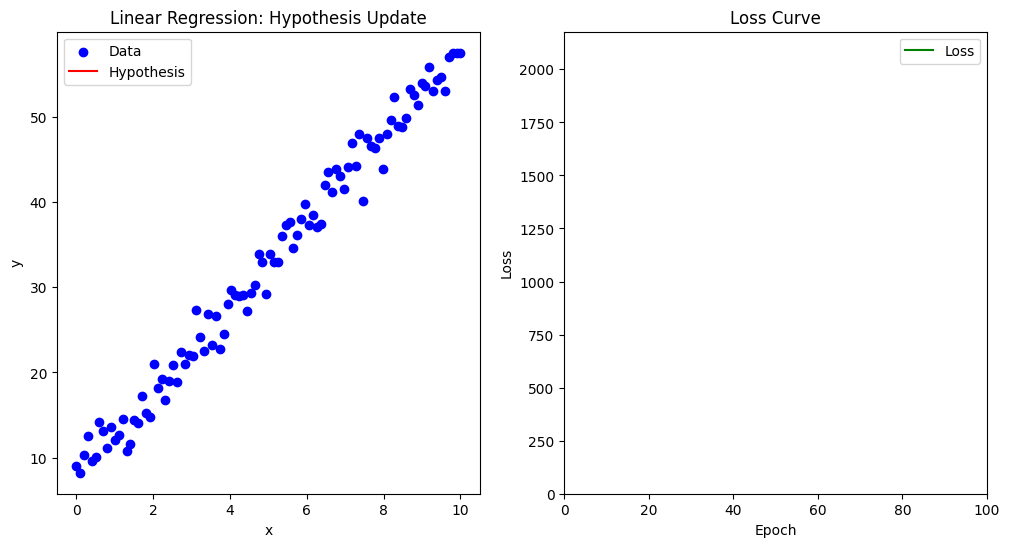

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Generate synthetic data
def generate_data(num_points=100):
    np.random.seed(42)
    x = np.linspace(0, 10, num_points)
    y = 5 * x + 8 + np.random.normal(scale=2, size=num_points)
    return x, y

# Hypothesis function
def predict(x, w, b):
    return w * x + b

# Gradient descent step
def gradient_descent_step(x, y, w, b, lr):
    y_pred = predict(x, w, b)
    error = y_pred - y

    # Gradients
    dw = (2 / len(x)) * np.dot(error, x)
    db = (2 / len(x)) * np.sum(error)

    # Update parameters
    w -= lr * dw
    b -= lr * db

    # Compute loss
    loss = np.mean(error**2)
    return w, b, loss

# Animation setup
x, y = generate_data()
num_epochs = 100
lr = 0.01

# Initialize parameters
w, b = np.random.randn(), np.random.randn()
losses = []
params = []

# Precompute gradient descent steps
for epoch in range(num_epochs):
    w, b, loss = gradient_descent_step(x, y, w, b, lr)
    losses.append(loss)
    params.append((w, b))

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left plot: Data points and hypothesis line
ax1.scatter(x, y, label="Data", color="blue")
hypothesis_line, = ax1.plot([], [], color="red", label="Hypothesis")
ax1.set_title("Linear Regression: Hypothesis Update")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()

# Right plot: Loss curve
ax2.set_xlim(0, num_epochs)
ax2.set_ylim(0, max(losses) * 1.1)
ax2.set_title("Loss Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
loss_curve, = ax2.plot([], [], color="green", label="Loss")
ax2.legend()

# Animation function
def update(frame):
    # Update hypothesis line
    w, b = params[frame]
    y_pred = predict(x, w, b)
    hypothesis_line.set_data(x, y_pred)

    # Update loss curve
    loss_curve.set_data(range(frame + 1), losses[:frame + 1])
    print(loss_curve)
    return hypothesis_line, loss_curve

# Create animation
anim = FuncAnimation(fig, update, frames=num_epochs, interval=30)
# Show animation

# ani.save('linear_regression.gif', writer='imagemagick')
plt.show()

In [161]:
%matplotlib notebook
fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)


anime = FuncAnimation(fig=fig, func=update, frames=40, interval=30)
# anime.save('test.gif', writer='imagemagick')